In [1]:
%pip install tensorflow
%pip install pyupbit

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyupbit as pb

In [3]:
df = pb.get_ohlcv("KRW-BTC", interval="day", count=1097, to = '20221202') #코로나 최초 보고일부터 현재(19/12/01~22/12/01)까지 불러오기
df

,open,high,low,close,volume,value
2019-12-01 09:00:00,8838000.0,8840000.0,8480000.0,8630000.0,3023.698278,2.606601e+10
2019-12-02 09:00:00,8630000.0,8705000.0,8415000.0,8585000.0,1837.439258,1.571477e+10
2019-12-03 09:00:00,8590000.0,8700000.0,8520000.0,8607000.0,1641.815953,1.414423e+10
2019-12-04 09:00:00,8607000.0,8996000.0,8432000.0,8515000.0,5171.381015,4.477820e+10
2019-12-05 09:00:00,8515000.0,8810000.0,8480000.0,8685000.0,3969.792297,3.435429e+10
...,...,...,...,...,...,...
2022-11-27 09:00:00,22646000.0,22774000.0,22605000.0,22646000.0,1989.051138,4.517556e+10
2022-11-28 09:00:00,22661000.0,22690000.0,22217000.0,22339000.0,3579.090571,8.021448e+10
2022-11-29 09:00:00,22329000.0,22617000.0,22155000.0,22417000.0,2523.908210,5.664776e+10
2022-11-30 09:00:00,22417000.0,23293000.0,22415000.0,23192000.0,4690.575205,1.075721e+11


In [4]:
seq = df[['close','open','high','low']].to_numpy() #종가, 오픈, 고가, 저가

In [5]:
seq

array([[ 8630000.,  8838000.,  8840000.,  8480000.],
       [ 8585000.,  8630000.,  8705000.,  8415000.],
       [ 8607000.,  8590000.,  8700000.,  8520000.],
       ...,
       [22417000., 22329000., 22617000., 22155000.],
       [23192000., 22417000., 23293000., 22415000.],
       [23002000., 23209000., 23400000., 22871000.]])

In [6]:
#시계열 데이터를 윈도우 단위로 자르는 함수
def seq2dataset(seq, window, horizon):
    X=[]
    Y=[]

    for i in range(len(seq) - (window + horizon) + 1):
        x = seq[i:(i + window)]
        y = (seq[i + window + horizon - 1])
        X.append(x)
        Y.append(y)

    return np.array(X), np.array(Y)

In [7]:
w= 7 #윈도우 크기
h= 1 #수평선 계수

X, Y =seq2dataset(seq, w, h)  #다중 채널 데이터의 텐서모양과 내용

print(X.shape, Y.shape)
print(X[0], Y[0])

(1090, 7, 4) (1090, 4)
[[8630000. 8838000. 8840000. 8480000.]
 [8585000. 8630000. 8705000. 8415000.]
 [8607000. 8590000. 8700000. 8520000.]
 [8515000. 8607000. 8996000. 8432000.]
 [8685000. 8515000. 8810000. 8480000.]
 [8813000. 8685000. 8852000. 8614000.]
 [8784000. 8815000. 8897000. 8776000.]] [8807000. 8784000. 8857000. 8670000.]


- x의 텐서모양 = 1704x7x4
- y의 텐서모양 = 1704x4

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [9]:
# 훈련집합과 테스트 집합으로 분할
split = int(len(X)*0.8)

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

In [10]:
#LSTM 모델의 설계와 학습
model = Sequential()
model.add(LSTM(units=128, activation='relu', input_shape=x_train[0].shape))
model.add(Dense(4))
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
hist= model.fit(x_train,y_train,epochs=200,batch_size=1,validation_data=(x_test,y_test),verbose=2)

Epoch 1/200
872/872 - 5s - loss: 4341761.5000 - mae: 4341761.5000 - val_loss: 1286716.7500 - val_mae: 1286716.7500 - 5s/epoch - 6ms/step
Epoch 2/200
872/872 - 3s - loss: 2841865.7500 - mae: 2841865.7500 - val_loss: 1080434.3750 - val_mae: 1080434.3750 - 3s/epoch - 4ms/step
Epoch 3/200


In [ ]:
#LSTM 모델 평가
ev=model.evaluate(x_test,y_test,verbose=0)
print("손실함수:",ev[0],"MAE:",ev[1])

손실함수: 812231.125 MAE: 812231.125


In [ ]:
#LSTM 모델로 예측 수행
pred=model.predict(x_test)
print("LSTM 평균절댓값백분율오차(MAPE):",sum(abs(y_test-pred)/y_test)/len(x_test))

7/7 [==============================] - 0s 5ms/step
LSTM 평균절댓값백분율오차(MAPE): [0.03237084 0.01792414 0.02093791 0.03609792]


MAPE
- 종가: 2.53%
- 오픈: 0.45%
- 고가: 1.89%
- 저가: 1.64%

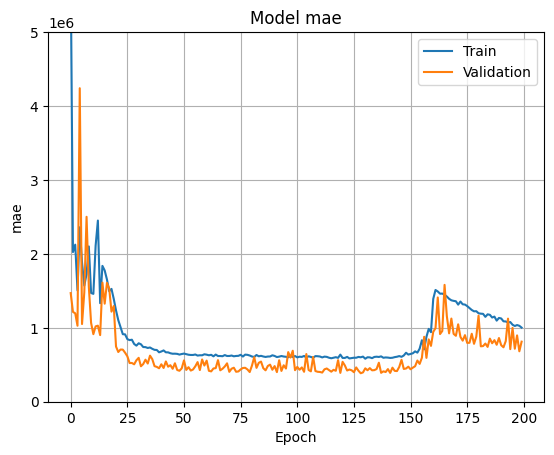

In [ ]:
#학습곡선
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.ylim([0,5000000])
plt.legend(['Train','Validation'],loc='best')
plt.grid()
plt.show()